In [14]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
%output size=110
from holoviews.core.options import Cycle

def nanowire_chain():
    lat = kwant.lattice.chain()
    syst = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))

    def onsite(onsite, p):
        return (2 * p.t - p.mu) * pauli.szs0 + p.B * pauli.s0sz + p.delta * pauli.sxs0

    syst[lat(0)] = onsite

    def hop(site1, site2, p):
        return -p.t * pauli.szs0 - .5j * p.alpha * pauli.szsx

    syst[kwant.HoppingKind((1,), lat)] = hop

    return syst


def spinful_kitaev_chain():
    lat = kwant.lattice.chain()
    syst = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))

    def onsite(site, p):
        return (2 * p.t - p.mu) * pauli.szs0 + p.B * pauli.szsz

    syst[lat(0)] = onsite

    def hop(site1, site2, p):
        return -p.t * pauli.szs0 - 1j * p.delta * pauli.sys0

    syst[kwant.HoppingKind((1,), lat)] = hop

    return syst


def find_gap(syst, p, resolution=1e-4):
    """Find gap in a system by doing a binary search in energy."""

    # This tells us if there are modes at a certain energy.
    if len(syst.modes(energy=0, args=[p])[0].momenta):
        return 0

    gap = step = min(abs(kwant.physics.Bands(syst, args=[p])(k=0))) / 2
    while step > resolution:
        step /= 2
        if len(syst.modes(gap, args=[p])[0].momenta):
            gap -= step
        else:
            gap += step

    return gap


def spinorbit_band_gap(syst, mu, t, delta, Bs):
    syst = syst.finalized()
    alphas = [0.0, 0.1, 0.2, 0.3]
    p = SimpleNamespace(mu=mu, t=t, delta=delta)

    def gap(syst, p, alpha, B):
        p.alpha = alpha
        p.B = B
        return find_gap(syst, p)

    gaps = [gap(syst, p, alpha, B) for alpha in alphas for B in Bs]
    gaps = np.reshape(gaps, (len(alphas), -1))
    dims = {'kdims': [r'$B$'], 'vdims': ['Band gap']}
    B_crit = holoviews.VLine(np.sqrt(p.delta**2 + p.mu**2))
    plot = [holoviews.Curve((Bs, gaps[i]), label=r'$\alpha={}$'.format(
        alphas[i]), **dims) * B_crit for i, alpha in enumerate(alphas)]
    title = r'$\Delta={:.2}$, $\mu={:.2}$'.format(p.delta, p.mu)
    style = {'xticks': [0, 0.1, 0.2, 0.3], 'yticks': [0, 0.05, 0.1], 'fig_size': 150}
    plot = holoviews.Overlay(plot)
    return plot(plot=style)


def title(p):
    try:
        title = r"$\alpha={:.2}$, $\mu={:.2}$, $B={:.2}$, $\Delta={:.2}$"
        title = title.format(p.alpha, p.mu, p.B, p.delta)
    except AttributeError:
        title = r"$\mu={:.2}$, $B={:.2}$, $\Delta={:.2}$"
        title = title.format(p.mu, p.B, p.delta)
    return title

style = {'k_x': np.linspace(-1, 1, 101),
         'xdim': r'$k$',
         'ydim': r'$E/t$',
         'xticks': [-1, 0, 1],
         'yticks': [-1, 0, 1],
         'xlims': [-1, 1],
         'ylims': [-1.5, 1.5],
         'title': title}

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex, plt, pf, display_html
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli
Using kwant 1.3.2 and holoviews 1.9.5
Executed on 2018-03-18 at 09:40:00.508150.


# From Kitaev model to an experiment

We have a special guest to begin this week's lecture, Yuval Oreg from the Weizmann Institute in Rehovot.

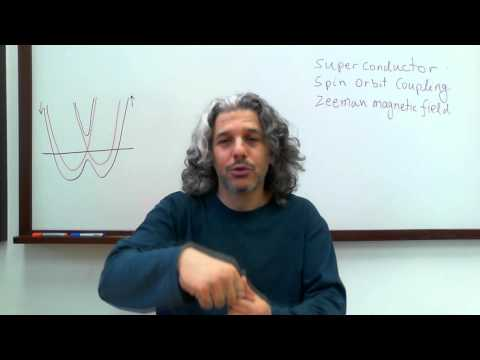

In [2]:
MoocVideo("GQLfs4i22ms", src_location="2.1-intro")

# Small parameters

We are now all set to make Majoranas in a real system. Or at least to invent a way to make Majoranas in a real system.

The way we approach this problem is by considering the Kitaev chain a 'skeleton', and 'dressing' it with real physics phenomena until it becomes real. 

> Interestingly, this is not at all how the condensed matter community came to this model. 
> Instead, the path to it was from complex to simple. The whole story started from what we'll consider in the very end of the course, fractional particles.

> Then it was simplified to topological superconductors (that still do not exist in nature, as far as we know).
> Majoranas were then predicted to exist (week 7) in a combination of a 3D topological insulator (week 6), which was then simplified to a two-dimensional topological insulator (week 5), and only after a few more simplification steps, the nanowire model was developed.

So once again, here is our 'skeleton', the Kitaev model Hamiltonian written in momentum space:

$$H_{Kitaev} = (-2 t \cos k -\mu) \tau_z + 2 \Delta \tau_y \sin k.$$

The model seems OK for a start, because it has some superconducting pairing $\Delta$ and some normal dispersion given by terms proportional to $\mu$ and $t$.

Before we proceed further, let's understand the relation between these parameters.

First of all, we want to make a controllable system, so that we can tweak its parameters. That means that we need a **semiconductor**. In semiconductors the electron density is very low, so that the chemical potential is near the bottom of the band. This makes it easier to define $\mu$ with respect to the bottom of the band:

$$\mu \rightarrow \mu - 2t.$$

Now the transition between trivial and non-trivial states happens when $\mu = 0$.

Of course semiconductors are never additionally superconducting. Luckily this is easy for us to resolve. We just paste a superconductor and semiconductor together into a hybrid structure, and let the superconductor induce superconductivity in the semiconductor. Making such a hybrid is extremely challenging from the material science point of view, but it's definitely not our problem for now.

The next thing we should consider is that $\mu$ will always stay small compared to the bandwidth, so $\mu \ll 2t$. The same holds for superconducting pairing: $\Delta \ll t$. This is because superconductivity is a very weak effect compared to the kinetic energy of electrons. These two inequalities combined mean that we can expand the $\cos k$ term and only work with the continuum limit of the Kitaev model:

$$H = (k^2/2m - \mu) \tau_z + 2 \Delta \tau_y k.$$

The effective electron mass $m$ is just the coefficient of the expansion. Let's take a look at the band structure in this regime, both in the topological regime and in the trivial regime:

In [15]:
holoviews.plotting.mpl.MPLPlot.fig_rcparams['text.usetex'] = False
syst = spinful_kitaev_chain()
p1 = SimpleNamespace(t=1.0, delta=0.1, mu=-0.3, B=0.0, alpha=0.0)
p2 = SimpleNamespace(t=1.0, delta=0.1, mu=0.3, B=0.0, alpha=0.0)

(spectrum(syst, p1, **style).relabel('Trivial bandstructure') +
 spectrum(syst, p2, **style).relabel('Topological bandstructure'))

:Layout
   .Path.Trivial_bandstructure     :Path   [$k$,$E/t$]
   .Path.Topological_bandstructure :Path   [$k$,$E/t$]

# The need for spin

Still, there is one obvious thing missing from the model, namely electron spin. This model works with some hypothetical spinless fermions, that do not really exist. So to make the model physical, we need to remember that every single particle has spin, and the Hamiltonian has some action in spin space, described by the Pauli matrices $\sigma$.

The simplest thing which we can do is to just add the spin as an extra degeneracy, that is to multiply every term in the Hamiltonian by $\sigma_0$. Obviously this doesn't change the spectrum, and a zero energy solution stays a zero energy solution.

Just kidding, this would be very bad! The problem about adding spin is that the whole point of a Kitaev chain is to create *unpaired* Majorana modes. If we add an extra spin degeneracy to these Majoranas, the edge of our chain will host two Majoranas, or in other words one regular fermion fine-tuned to zero energy.

What's the correct way of introducing spin then? We still need to add it. Let's add spin such that the Kitaev chain corresponding to one spin species is topologically trivial, and the Kitaev chain corresponding to the other spin species non-trivial. We know that the chemical potential $\mu$ controls whether a Kitaev chain is topological or trivial, so if say spin up has $\mu > 0$ and spin down $\mu < 0$, we're back in business.

We achieve this by adding Zeeman coupling of the spin to an external magnetic field:

$$H = (k^2/2m - \mu - B \sigma_z) \tau_z + 2 \Delta \tau_y k.$$

Whenever the Zeeman energy $|B|$ is larger than $\mu$ we have one Majorana fermion at the end of the chain.

Let's look at what happens with the dispersion as we increase the magnetic field from zero to a value larger than $\mu$.

In [16]:
syst = spinful_kitaev_chain()
p = SimpleNamespace(t=1.0, delta=0.1, mu=0.3, B=None)
Bs = np.linspace(0, 0.4, 10)
holoviews.HoloMap({p.B: spectrum(syst, p, **style) for p.B in Bs}, kdims=[r'$B$'])

:HoloMap   [$B$]
   :Path   [$k$,$E/t$]

We now see that we resolved the first problem:

> A high enough **Zeeman splitting** allows to separate the different spins.
> Then we can make one spin species trivial, while the other one is topological and hosts Majoranas.

# Realistic superconducting pairing

The next part for us to worry about is the superconductor.

Something that you probably saw in the Kitaev chain Hamiltonian is that the superconducting pairing $\Delta$ has a peculiar form. It pairs electrons from *neighboring* sites, and not those from the same site. In momentum space this means that the superconducting pairing is proportional to $\Delta k$.

Of course, in a Kitaev chain the superconducting pairing cannot couple two electrons from the same site since there is just one particle per site!

Real world superconductors are different. Most of them, and specifically all the common superconductors like $Al$, $Nb$, $Pb$, $Sn$ have $s$-wave pairing. This means that the pairing has no momentum dependence, and is local in real space. The Kitaev chain pairing is proportional to the first power of momentum and so it is a $p$-wave pairing.

[High temperature superconductors](https://en.wikipedia.org/wiki/High-temperature_superconductivity) like cuprates or pnictides do have a momentum-dependent pairing, but it's yet another type ($d$-wave, or a more exotic $s\pm$-wave).

So if we want to invent a way to make Majoranas, we will need to use $s$-wave pairing. And then, as you should remember from the previous week, due to the fermionic statistics the pairing function should be antisymmetric. In a Kitaev chain the antisymmetry is due to the real space structure of the pairing, but in an $s$-wave superconductor, the antisymmetry of the pairing should arise due to its spin structure.

This leaves only one option. All the $s$-wave superconductors are spin-singlet:

$$H_{pair} = \Delta(c_\uparrow c_\downarrow - c_\downarrow c_\uparrow) + \text{h.c.}$$

This means that now we need to modify the pairing, but before that we'll need to do one other important thing.

### Important and useful basis change.

When you see Bogoliubov-de-Gennes Hamiltonians in the literature, you will find them written in two different bases.
One variant is the one which we introduced last week:

$$
H_\textrm{BdG} = \begin{pmatrix} H & \Delta \\ -\Delta^* & -H^* \end{pmatrix}.
$$

It has the particle-hole symmetry $H_\textrm{BdG} = - \tau_x H^*_\textrm{BdG} \tau_x$. In this basis, the $s$-wave pairing is proportional to $\sigma_y$.

However for systems with complicated spin and orbital structure, there is a different basis which makes the bookkeeping much easier.

If we have a time-reversal symmetry operator $\mathcal{T} = U \mathcal{K}$, we can apply the unitary transformation $U$ to the holes, so that in the new basis we get the Bogoliubov-de-Gennes Hamiltonian

$$
H_\textrm{BdG} = \begin{pmatrix} H & \Delta' \\ \Delta'^\dagger & -\mathcal{T} H \mathcal{T}^{-1}\end{pmatrix},
$$

with $\Delta' = \Delta U^\dagger$.

Why is this basis useful?

* First of all, because in this new basis the $s$-wave pairing is a unit matrix regardless of system we consider.
* Second, because it's easy to get the Hamiltonian of holes. We take the Hamiltonian for electrons, and change the signs of all terms that respect time-reversal symmetry, but not for those that break it, such as the term proportional to the magnetic field $B$. So if the electrons have a Hamiltonian $H(B)$, the Hamiltonian of the holes just becomes $-H(-B)$.

There is one disadvantage. The particle-hole symmetry now becomes more complicated. For our system with only one orbital and spin it is $\mathcal{P} = \sigma_y \tau_y \mathcal{K}$. But, let us tell you, the advantages are worth it.

### My Note : 

Hamiltonian in original basis is $H_\textrm{BdG} = \begin{pmatrix} H & \Delta \\ -\Delta^* & -H^* \end{pmatrix}$ with wave function $\begin{pmatrix}u \\ v  \end{pmatrix}$

In the new basis which THS is in the form  $\mathcal{T} = U \mathcal{K}$, Hamiltonian becomes
$H_\textrm{BdG} = \begin{pmatrix} H & \Delta' \\ \Delta'^\dagger & -\mathcal{T} H \mathcal{T}^{-1}\end{pmatrix}$ with wave function  $\begin{pmatrix}u \\ Uv  \end{pmatrix}$

The new operators becomes
$$C' =
  \begin{pmatrix}
       c'_1 \\
       c'_2 \\
       \vdots \\
       c'_n  \\
       c'^\dagger_1 \\
       c'^\dagger_2 \\
       \vdots \\
       c'^\dagger_n
     \end{pmatrix}
     = \begin{pmatrix} 1 & 0 \\ 0 & U  \end{pmatrix}
  \begin{pmatrix}
       c_1 \\
       c_2 \\
       \vdots \\
       c_n  \\
       c^\dagger_1 \\
       c^\dagger_2 \\
       \vdots \\
       c^\dagger_n
     \end{pmatrix}
$$

# s-wave superconductor with magnetic field

Let's look at how our chain looks once we change the superconducting coupling to be $s$-wave. The Zeeman field (or anything of magnetic origin) changes sign under time-reversal symmetry. 

This means that the Zeeman field has the same form for electrons and for holes in the new basis, and the full Hamiltonian is now:

$$
H_\textrm{BdG} = (k^2/2m - \mu)\tau_z + B \sigma_z + \Delta \tau_x.
$$

This Hamiltonian is easy to diagonalize since every term only has either a $\tau$ matrix or a $\sigma$ matrix. At $k=0$ it has 4 levels with energies $E = \pm B \pm \sqrt{\mu^2 + \Delta^2}$.

We can use this expression to track the crossings. We also know that when $B=0$ the system is trivial due to spin degeneracy.
Together this means that we expect the system to be non-trivial (and will have a negative Pfaffian invariant) when

$$ B^2 > \Delta^2 + \mu^2.$$

Are we now done? Not quite.

### My Note :

After the Fourier transform, $H = (k^2/2m - \mu - B \sigma_z) \tau_z + 2 \Delta \tau_y k = H_\textrm{BdG} = \begin{pmatrix} H_0 + B \sigma_z & -2ik \Delta \\ 2ik \Delta & -H_0 + B \sigma_z \end{pmatrix}$ where $ H_0 = k^2/2m - \mu $. 

(note1) Top-right block matrix is no longer anti-symmetric.

(note2) $H_{BdG}$ is no longer in the form $ \begin{pmatrix} H & \Delta \\ -\Delta^* & -H^* \end{pmatrix}$.

The basis transform realizing $\mathcal{T} = \mathcal{K}\rightarrow \mathcal{T} = U \mathcal{K}$ is still applicable to the Hamiltonian $\begin{pmatrix} H_0 + B \sigma_z & -2ik \Delta \\ 2ik \Delta & -H_0 + B \sigma_z \end{pmatrix}$. Here $U = i\sigma_y$ on spin basis. 

Write out the transformation of creation operator explicitly: $ C = 
\begin{pmatrix}
    \begin{array}{@{}@{}}
       c_{\uparrow k_1} \\
       c_{\downarrow k_1} \\
       \vdots \\
       c_{\uparrow k_n}  \\
       c_{\downarrow k_n}  \\\hline
       c^\dagger_{\uparrow -k_1} \\
       c^\dagger_{\downarrow -k_1} \\
       \vdots \\
       c^\dagger_{\uparrow -k_n}  \\
       c^\dagger_{\downarrow -k_n}  
       \end{array}
     \end{pmatrix}
\rightarrow
C' = \begin{pmatrix} 1&0\\0&i\sigma_y \end{pmatrix} C = 
  \begin{pmatrix}
    \begin{array}{@{}@{}}
       c_{\uparrow k_1} \\
       c_{\downarrow k_1} \\
       \vdots \\
       c_{\uparrow k_n}  \\
       c_{\downarrow k_n}  \\\hline
       c^\dagger_{\downarrow -k_1} \\
      -c^\dagger_{\uparrow -k_1} \\
       \vdots \\
       c^\dagger_{\downarrow -k_n}  \\
      -c^\dagger_{\uparrow -k_n}  
       \end{array}
     \end{pmatrix}
$  **Nambu spinors**


So in the new basis which $\mathcal{T} = i\sigma_y \mathcal{K}$, new Hamiltonian $H =\begin{pmatrix} H_0 + B \sigma_z & -2ik \Delta (-i\sigma_y) \\ (i\sigma_y) 2ik \Delta & -(i\sigma_y) \mathcal{K} (H_0 + B\sigma_z)\mathcal{K} (-i\sigma_y)\end{pmatrix} = \begin{pmatrix} H_0 + B \sigma_z & 2k\Delta \sigma_y \\-2k \Delta \sigma_y & -H_0 + B\sigma_z \end{pmatrix}$

This is for triplet pairing case. 

For singlet pairing $\Delta(c_\uparrow c_\downarrow - c_\downarrow c_\uparrow) + \text{h.c.} = 
\begin{pmatrix} c_\uparrow \\ c_\downarrow \\ c^\dagger_\uparrow \\ c^\dagger_\downarrow \end{pmatrix}^\dagger 
\Delta \begin{pmatrix} \begin{array}{@{}cc|cc@{}} 0&0&0&-1 \\ 0&0&1&0 \\\hline 0&1&0&0 \\ -1&0&0&0\end{array}\end{pmatrix} 
\begin{pmatrix} c_\uparrow \\ c_\downarrow \\ c^\dagger_\uparrow \\ c^\dagger_\downarrow \end{pmatrix}
= \begin{pmatrix}\begin{array}{@{}c|c@{}} 0 & -i \Delta \sigma_y \\\hline i \Delta \sigma_y & 0\end{array}\end{pmatrix}$. 

In the new basis with  $C = \begin{pmatrix} c_\uparrow \\ c_\downarrow \\c^\dagger_\downarrow \\-c^\dagger_\uparrow \end{pmatrix}$, 
$\Delta(c_\uparrow c_\downarrow - c_\downarrow c_\uparrow) + \text{h.c.} = 
\begin{pmatrix} c_\uparrow \\ c_\downarrow \\ c^\dagger_\downarrow \\ -c^\dagger_\uparrow \end{pmatrix}^\dagger 
\Delta \begin{pmatrix} \begin{array}{@{}cc|cc@{}} 0&0&-1&0 \\ 0&0&0&-1 \\\hline -1&0&0&0 \\ 0&-1&0&0\end{array}\end{pmatrix}
\begin{pmatrix} c_\uparrow \\ c_\downarrow \\ c^\dagger_\downarrow \\ -c^\dagger_\uparrow \end{pmatrix}$

So new Hamiltonian $H = \begin{pmatrix} H_0 + B \sigma_z & -\Delta \\ -\Delta & -H_0 + B\sigma_z \end{pmatrix} = (k^2/2m - \mu)\tau_z + B \sigma_z - \Delta \tau_x$. Different from the main text above with a minus sign..... maybe I should start the derivation from the pairing : $\Delta(-c_\uparrow c_\downarrow + c_\downarrow c_\uparrow) + \text{h.c.}$.

### Problem with singlets

A singlet superconductor has an important property: Since electrons are created in singlets, the total spin of every excitation is conserved. Zeeman field conserves the spin in $z$-direction, so together every single state of our system has to have a definite spin, *including the Majoranas*.

And that is a big problem. Majoranas are their own particle-hole partners, and that means that they cannot have any spin (energy, charge, or any other observable property at all).

So does this now mean that we "broke" the bulk-edge correspondence? Let's look at the band structure (tweak the Zeeman energy):

In [5]:
syst = nanowire_chain()
p = SimpleNamespace(t=1.0, mu=0.0, delta=0.1, alpha=0.0, B=None)
Bs = np.linspace(0, 0.4, 10)
holoviews.HoloMap({p.B: spectrum(syst, p, **style) for p.B in Bs}, kdims=[r'$B$'])

:HoloMap   [$B$]
   :Path   [$k$,$E/t$]

Of course we didn't break bulk-edge correspondence. Majoranas in our system would have to have a spin, which isn't possible. That in turn means that they cannot appear, and that means that the system cannot be gapped.

We can also approach this differently. From all the spin Pauli matrices, only $\sigma_z$ appears in the Hamiltonian, so there's a conservation law. The two bands that cross at zero energy in the band structure above belong to opposite spin bands, and so cannot be coupled.

Now we need to solve this final problem before we are done.

# How to open the gap?

The final stretch is straightforward.

We know that there is no gap because of conservation of one of the spin projections, so we need to break the spin conservation.

If we don't want to create an inhomogeneous magnetic field, we have to use a different term that couples to spin. That term is spin-orbit interaction. In it's [simplest form](http://en.wikipedia.org/wiki/Rashba_effect) this interaction appears in our wire as

$$H_{SO} = \alpha \sigma_y k,$$

so it is like a Zeeman field pointing in $y$-direction with a strength proportional to the particle momentum. Note that this term is invariant under time reversal symmetry (both $\sigma_y$ and $k$ change sign). So now we have our final Hamiltonian:

$$
H_\textrm{wire} = (k^2/2m + \alpha \sigma_y k - \mu)\tau_z + B \sigma_z + \Delta \tau_x.
$$

At $k = 0$, spin-orbit coupling vanishes, so it has no effect on the system being topologically trivial or non-trivial.

Let's now check that it does what we want, namely open the gap at a finite momentum:

In [6]:
syst = nanowire_chain()
p = SimpleNamespace(t=1.0, mu=0.1, delta=0.1, B=0.2, alpha=None)
alphas = np.linspace(0, 0.4, 10)
holoviews.HoloMap({p.alpha: spectrum(syst, p, **style) for p.alpha in alphas}, kdims=[r'$\alpha$'])

:HoloMap   [$\alpha$]
   :Path   [$k$,$E/t$]

Yep, it does :)

An important remark: You might now think that since spin-orbit interaction depends on spin, it makes the magnetic field unnecessary. This is not true: Since spin-orbit interaction preserves time-reversal symmetry, in the absence of a magnetic field the energy spectrum of the model would have a *Kramers degeneracy*, as you learned last week. To get one unpaired Majorana mode per edge and not two, we need to break Kramers degeneracy and therefore break time-reversal symmetry. So the combination of both Zeeman field and spin-orbit coupling is needed.

# Putting everything together

Let's now rest for a moment and reflect on what we have done.

We started from a toy model, which has a very special feature. Then one by one we fixed the parts of the model that we found unrealistic and ended up with a new system. It still has a relatively simple Hamiltonian, but already gives hope of being realizable in a lab.

Now try to guess: how many papers were written studying this exact model? The exact number is hard to obtain, but the count is in the hundreds!

Despite the model being very simple and the fact that it can be written in one line, it has four independent parameters already in our simplest formulation. Let's enumerate the parameters once again:

* The chemical potential $\mu$, which sets the overall electron density in the wire.
* The induced superconducting gap $\Delta$, which is required to make particle-hole symmetry play a role.
* The spin-orbit coupling $\alpha$, which breaks spin conservation.
* The Zeeman field $B$, which breaks Kramers degeneracy.

We need to control every single parameter out of these 4 to create Majoranas (and there are even more). This is why the task of creating Majoranas is extremely challenging.

As a final point in our story, let's see how the four parameters work together in determining how large the gap in our system is.

Obviously, this is the key parameter that we care about when creating Majoranas.
The smaller the gap, the worse the protection of Majoranas, and the more we need to worry about the effects of finite temperature.

Let's calculate the gap as a function of all of the relevant parameters.

In [7]:
%%opts Curve (color=Cycle(values=['r', 'g', 'b', 'y']))
%%opts Overlay [show_legend=True legend_position='top']

syst = nanowire_chain()
Bs = np.linspace(0, 0.3, 71)
mus = np.linspace(-0.05, 0.15, 5)
holoviews.HoloMap({mu: spinorbit_band_gap(syst, mu, 1.0, 0.1, Bs) for mu in mus}, kdims=[r'$\mu$'])

:HoloMap   [$\mu$]
   :Overlay
      .Curve.Reverse_over_alpha_equals_0_full_stop_0 :Curve   [$B$]   (Band gap)
      .VLine.I                                       :VLine   [x,y]
      .Curve.Reverse_over_alpha_equals_0_full_stop_1 :Curve   [$B$]   (Band gap)
      .VLine.II                                      :VLine   [x,y]
      .Curve.Reverse_over_alpha_equals_0_full_stop_2 :Curve   [$B$]   (Band gap)
      .VLine.III                                     :VLine   [x,y]
      .Curve.Reverse_over_alpha_equals_0_full_stop_3 :Curve   [$B$]   (Band gap)
      .VLine.IV                                      :VLine   [x,y]

Here the vertical line denotes the critical value of the Zeeman field at which the wire becomes topological.

Let's summarize our observations:

* So we see that the closer $\mu$ is to 0, the lower $B$ is required to reach the topological regime.
* After reaching the topologically nontrivial regime, the gap slowly grows as we go away from the transition region, and after reaching its peak value, it starts dropping.
* Finally, we see that the higher the spin-orbit coupling, the larger the optimal gap in the topological regime.

We finish our investigation of this model for now with a final simple picture of the band structure of our system.

In [20]:
syst = nanowire_chain()
p = SimpleNamespace(t=1.0, B=0.15, delta=0.03, alpha=0.8, mu=None)
mus = np.linspace(-0.4, 0.4, 50)
holoviews.HoloMap({p.mu: spectrum(syst, p, **style) for p.mu in mus}, kdims=[r'$\mu$'])

:HoloMap   [$\mu$]
   :Path   [$k$,$E/t$]

When $\mu$ is very negative we see two split electron bands at positive energy corresponding to two spin orientations.

The lower of these two bands has a characteristic double minimum due to spin-orbit coupling.

As we increase $\mu$, the bands move down in energy, until they couple with the hole bands at $E=0$. This only happens due to the combination of superconductivity and spin-orbit coupling.

At $k=0$ the spin-orbit coupling is ineffective, so the electron and hole bands pass through each other, changing the system first from trivial to topological and then back.

The non-monotonous behavior of the gap versus $B$ that we saw earlier is a consequence of this complicated band structure: There are different values of momenta where the dispersion has local minima. When we are close to the phase transition, $k=0$ defines the gap, while for large $B$, it is the gap at finite momentum that becomes smallest.

In [9]:
question = ("What happens if we align the magnetic field $B$ along the $y$-direction instead of the $z$-direction?")
answers = ["Then we do not need spin-orbit coupling anymore in order to get Majoranas.",
           "Then the spin projection along the $y$ direction is conserved, so we can't get Majoranas.",
           "It's impossible, because a magnetic field can only be applied along $z$.",
           "Then the spin-orbit term is automatically modified to point along the $z$ direction, so nothing really changes."]
explanation = ("If both the magnetic field and the spin orbit coupling point in the $y$ direction, " +
               "then the Hamiltonian commutes with $\sigma_y$, and spin projection along $y$ is a good quantum number. " +
               "So we are back to the problem that a gap at finite momentum does not open, " +
               "and we do not get a topological phase supporting Majoranas.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'If both the magnetic field and the spin orbit coupling point in the $y$ direction, then the Hamiltonian commutes with $\\sigma_y$, and spin projection along $y$ is a good quantum number. So we are back to the problem that a gap at finite momentum does not open, and we do not get a topological phase supporting Majoranas.', 'display_name': 'Question', 'max_attempts': 2, 'correct_answer': 1, 'answers': ['Then we do not need spin-orbit coupling anymore in order to get Majoranas.', "Then the spin projection along the $y$ direction is conserved, so we can't get Majoranas.", "It's impossible, because a magnetic field can only be applied along $z$.", 'Then the spin-orbit term is automatically modified to point along the $z$ direction, so nothing really changes.'], 'question': 'What happens if we align the magnetic field $B$ along the $y$-direction instead of the $z$-direction?'})

# Outlook

In [ ]:
MoocVideo("MsFyJBAMFLI", src_location="2.1-summary")

In [ ]:
MoocDiscussion("Questions", "Majoranas in nanowires")